<a href="https://colab.research.google.com/github/Davilirio/Python_data_analysis/blob/master/timeseries_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analise de series temporais em python

## Importando as dependencias


In [ ]:
!pip install stldecompose

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import statsmodels.api as sm
import stldecompose
import datetime as dt
import statsmodels.tsa.stattools as stats

from statsmodels.graphics.tsaplots import plot_pacf
from dateutil import relativedelta
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from scipy.ndimage.interpolation import shift
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from google.colab import drive, files

path = ""
drive.mount('/content/drive/', force_remount = True)

%matplotlib inline
plt.style.use('seaborn-dark')
plt.figure(figsize = (12, 8));

Mounted at /content/drive/


<Figure size 864x576 with 0 Axes>

## Analise de random walks:

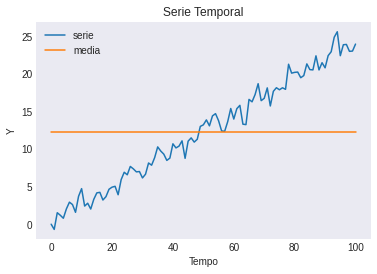

In [ ]:
def serie_temporal(tempo = 100, beta1 = 0, beta2 = 1, beta3=0):
  """
  O default é Random Walk
  """

  time = [0]
  # tend = tendencia
  yt = [beta1]
  erros = []
  for i in range(tempo):
    erro = np.random.randn()
    erros.append(erro)
    time.append(time[-1] + 1)
    yt.append(beta1 + beta2*yt[-1]  + beta3*time[-1] + erros[-1])

  linha_media = [np.mean(yt) for i in yt]
  plt.xlabel('Tempo')
  plt.ylabel('Y')
  plt.title('Serie Temporal')
  plt.plot(time,  yt, label = 'serie')
  plt.plot(time, linha_media, label = 'media')
  plt.legend()
  plt.show()

  return yt, time


# Para printarmos o a serie, basta inserir o valor de beta1, a tendencia e 
# o beta 2 respectivamente na funcao abaixo:

serie, time = serie_temporal(beta3 = 0.2, beta2 = 0.2)

#### Aqui criamos duas variaveis completamente randomicas e regredimos uma na outra pra expormos o fenomeno de regressao espuria:

In [ ]:
# Criando 501 observacoes de duas variaveis de forma completamente randomica:

yt = [0]
xt = [0]
erros_xt = []
erros_yt = []
for i in range(500):
  erros_xt.append(np.random.randn())
  xt.append(xt[-1]+erros_xt[-1])
  erros_yt.append(np.random.randn())
  yt.append(yt[-1]+erros_yt[-1])

len(xt)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


501

In [ ]:
modelo = sm.OLS(yt, xt)
resultado = modelo.fit()
serie_sem_tendencia  = resultado.resid
print(resultado.summary())

# plt.plot(serie_sem_tendencia)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.695
Model:                            OLS   Adj. R-squared (uncentered):              0.694
Method:                 Least Squares   F-statistic:                              1139.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):                   5.69e-131
Time:                        13:29:43   Log-Likelihood:                         -1931.9
No. Observations:                 501   AIC:                                      3866.
Df Residuals:                     500   BIC:                                      3870.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Retirando tendencia da serie:

In [ ]:
import statsmodels.api as sm

original = serie
tira_tend = sm.OLS(serie, time)
reg = tira_tend.fit()
sem_tendencia = reg.resid
# sem_tendencia_dif = np.diff(sem_tendencia)
linha_media  = [np.mean(sem_tendencia) for i in sem_tendencia]

# Pltando os graficos da serie com tendencia e da serie sem tendencia:


plt.plot(sem_tendencia, label = 'Destendenciada')
plt.plot(original, label = 'Tendenciada')
plt.plot([np.mean(original) for i in original], label = 'Media Original')
plt.plot(linha_media, label = 'Media Destendenciada')
plt.title('Comparacao Series com/sem Tendencia Temporal')
plt.xlabel('Tempo')
plt.ylabel('Yt')
plt.legend()
plt.show()
# original

## Testes de Series Temporais

## FAC

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Aulas econometria LAB/series_econ2.csv', delimiter = ';' )
df['Data'] = df['Data'].apply(lambda x: 
                                    dt.datetime.strptime(str(x),'%Y.%m'))

df['vendas_varejo'] = df['vendas_varejo'].apply(lambda x: float(x.replace(',', '.')))

df.set_index(df['Data'], inplace = True)
df.drop(labels = ('Data'), axis = 1, inplace = True)

def fac(serie, lags):
  params = list()
  for i in range(lags):
    fac_def = sm.OLS(serie[:len(serie)-i], serie[i:])
    fac_def = fac_def.fit()
    params.append(float(fac_def.params))
    confidence = fac_def.params - 1.96*np.std(serie)
    print(f'Defasagem {i}: {fac_def.params} conf: {confidence} \n |---------------- \n')  
  return params

def acf_by_hand(x, lag = 20):
    for i in range(lag):
      y1 = x[:(len(x)-i)]
      y2 = x[i:]
      # Subtract the mean of the whole series x to calculate Cov
      cov = np.sum((y1-np.mean(x))*(y2-np.mean(x))) / len(x)
      # Normalize with var of whole series
      var = np.sum((y1 - np.mean(x))**2) / len(x)
      fac = cov/var
      print(fac)

def fac_serie(serie, nome = 'Sem nome indicado'):

  sm.graphics.tsa.plot_acf(np.array(serie), lags = 100,
                          title = f'Autocorrelacao da serie: {str(nome)}')
  plt.show()

  return 

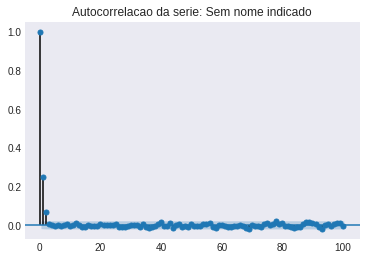

In [ ]:
serie = [25]
erros = []

for n in range(10000):
    erro = np.random.ranf()
    erros.append(erro)
    serie.append((25 +(0.25*serie[n])+erro))

fac_serie(serie)

#### Usando o pandas autocorrelation plot:

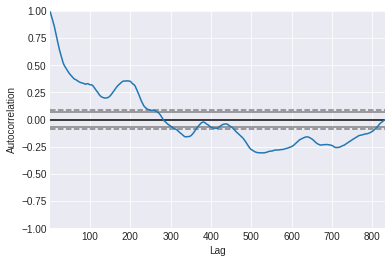

In [ ]:
autocorrelation_plot(milho['preco reais']);

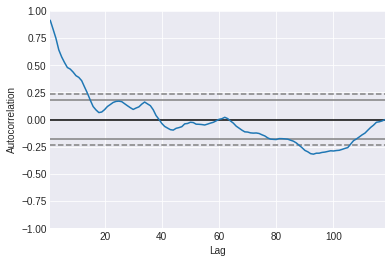

In [ ]:
autocorrelation_plot(suinos_pr['PR']);

## Teste de raiz unitaria

In [ ]:
def unit_root_test(yt, nome = 'Serie sem nome indicado', **kwargs):

  plt.plot(yt)
  plt.title(nome)
  plt.xlabel('Observacoes')
  plt.ylabel('Valor da variavel')
  plt.show()

  unit_root = sm.OLS(np.diff(yt), yt[1:], hasconst = yt[0])
  unit_root_results = unit_root.fit()
  gamma = unit_root_results.params[0]
  coef_original = 1+gamma
  print(f'O valor de Gamma é {gamma}, portanto, tem-se que o valor do beta é aprox. {coef_original} \n')
  test = adfuller(yt, regression = 'c')
  adf_stat = np.abs(test[0])
  mckinnon = test[1]
  crit_5 = np.abs(test[4]['5%'])
  # print(test)
  if adf_stat < crit_5:
    print(f'De acordo com o teste de ADF, temos que tau (absoluto) = {adf_stat} enquanto o 5% critico = {crit_5}\n \
    Portanto, temos uma serie nao estacionaria')
  else:
    print(f'De acordo com o teste de ADF, temos que tau (absoluto) = {adf_stat} enquanto o 5% critico = {crit_5}\n \
    Portanto, temos uma serie estacionaria')

  print('\n FAC:')
  sm.graphics.tsa.plot_acf(np.array(yt), lags = 35,
                          title = f'Autocorrelacao da serie: {str(nome)}')
  plt.show()

  return   
 
# unit_root_test(df['vendas_varejo'].values)

In [ ]:
serie_ex = [480,392,350,330,310,298,290,270,289,195,210,195,186,140,160,135,130,85,111,70,60,40,42,34,42,40,38,25,30,25,20,23,11,10,3,0]

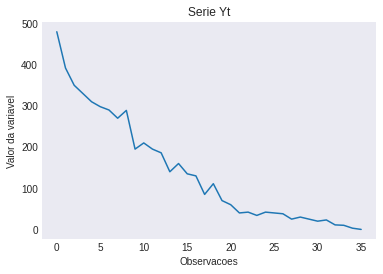

O valor de Gamma é -0.09257228815283504, portanto, tem-se que o valor do beta é aprox. 0.907427711847165 

De acordo com o teste de ADF, temos que tau (absoluto) = 0.2659823026151531 enquanto o 5% critico = 3.5630415894061964
     Portanto, temos uma serie estacionaria

 FAC:


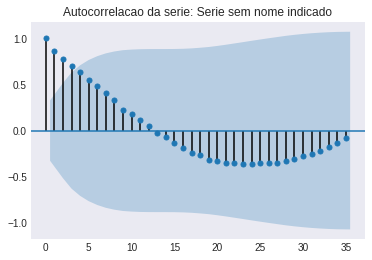

In [ ]:
unit_root_test(serie_ex)

## Analise de Cointegracao das series temporais


Analise de Cointegracao entre Suinos e preco do milho


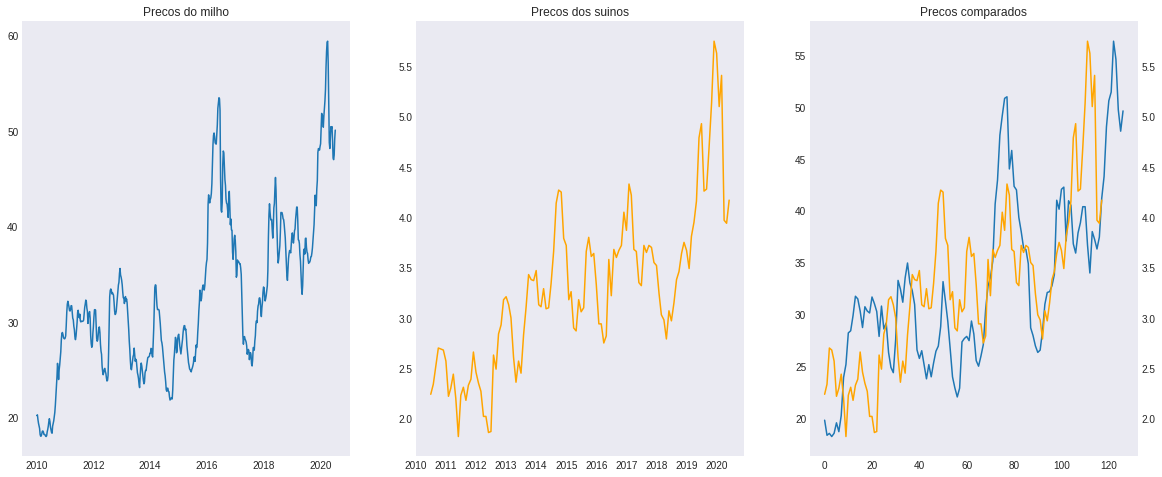

In [ ]:
# print(f'Analise de Cointegracao entre Suinos e preco do milho')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 8))

ax1.plot(milho_s.index, milho_s['preco reais'].values)
ax1.set_title('Precos do milho', size = 12)

ax2.plot(suinos.index, suinos['PR'].values,  color = 'orange')
ax2.set_title('Precos dos suinos', size = 12)


ax3.plot(milho_s.resample('M').mean()['preco reais'].values)
ax4 = ax3.twinx()
ax4.plot(suinos['PR'].values, color = 'orange')
ax3.set_title('Precos comparados', size = 12)

plt.show()

In [ ]:
Ano = suinos['Ano']
mes = suinos['Mês']
data = []
for e, i in enumerate(Ano):
  valor = '01'+'/'+ str(mes[e]) + '/' + str(i)
  data.append(valor)

suinos['data'] = data

In [ ]:
suinos['data'] = pd.to_datetime(suinos['data'], format = '%d/%m/%Y')
suinos.set_index('data', inplace = True)

In [ ]:
milho_s = milho_s.loc[milho_s.index > '2010']

In [ ]:
suinos['PR'] = [float(str(i).replace(',', '.')) for i in suinos['PR'].values]
suinos

,Ano,Mês,MG,PR,RS,SC,SP
data,,,,,,,
2010-07-01,2010,7,"2,74",2.24,"2,22","2,21","2,58"
2010-08-01,2010,8,"2,99",2.34,"2,25","2,36","2,73"
2010-10-01,2010,10,"3,28",2.70,"2,66","2,75","3,11"
2010-12-01,2010,12,"3,25",2.68,"2,67","2,67","3,1"
2011-01-01,2011,1,"3,07",2.57,"2,59","2,63","2,93"
...,...,...,...,...,...,...,...
2020-02-01,2020,2,"5,57",5.10,"4,86","4,92","5,37"
2020-03-01,2020,3,"5,69",5.41,"5,16","5,3","5,75"
2020-04-01,2020,4,"4,14",3.97,"3,96","3,79","4,31"


In [ ]:
reg = sm.OLS(suinos['PR'].values,milho_s['preco reais'].resample('M').mean().values[:118])
erros_suino_milho = reg.fit().resid
reg.fit().summary()

In [ ]:
MCE = pd.DataFrame({'diff_suinos':diff_suinos})
MCE['diff_milho'] = diff_milho
MCE['erros_defas'] = erros_suino_milho_def

In [ ]:
## Fazendo o mecanismo de correcao de erros:


diff_suinos = np.diff(suinos['PR'].values)
diff_milho = np.diff(milho_s['preco reais'].resample('M').mean().values[:118])
erros_suino_milho_def = shift(erros_suino_milho, 1)[1:]
X = [diff_milho, erros_suino_milho_def]
erros_suino_milho_def = np.insert(erros_suino_milho_def, 0, 0)
MCE_ = sm.OLS(diff_suinos, X)

In [ ]:
result = MCE_.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            diff_suinos   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     10.63
Date:                Fri, 10 Jul 2020   Prob (F-statistic):            0.00146
Time:                        12:55:52   Log-Likelihood:                -22.233
No. Observations:                 117   AIC:                             48.47
Df Residuals:                     115   BIC:                             53.99
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
diff_milho     -0.0053      0.012     -0.449      0.654      -0.029       0.018
erros_defas    -0.1208      0.037     -3.238      0.002      -0.195      -0.047
==============================================================================
Omnibus:                       13.193   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.083
Skew:                          -0.404   Prob(JB):                     1.32e-06
Kurtosis:                       5.214   Cond. No.                         3.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Decomposicao de Series Temporais

### **Suinos**

In [ ]:
suinos = pd.read_csv('/content/drive/My Drive/Grupo 1 Econometria/suino_preco.csv')

Ano = suinos['Ano']
mes = suinos['Mês']
data = []
for e, i in enumerate(Ano):
  valor = '01'+'/'+ str(mes[e]) + '/' + str(i)
  data.append(valor)

suinos['PR'] = [float(str(i).replace(',', '.')) for i in suinos['PR'].values]
suinos['data'] = data
suinos['data'] = pd.to_datetime(suinos['data'], format = '%d/%m/%Y')
suinos = suinos.set_index('data').resample('M').mean()
suinos_pr = pd.DataFrame(suinos['PR'])
A = suinos_pr['PR'].values
np.isnan(A)
for e, i in enumerate(A):
  if np.isnan(i):
    # print(e+1)
    A[e] = np.mean([A[e-1], A[e+1]])
suinos_pr['PR'] = A

dummyt2 = list()
dummyt1 = list()

for i in suinos_pr.index:
  if i.year == 2018 and i.month >= 5:
      dummyt1.append(0)
      dummyt2.append(1)
  elif i.year > 2018:
    dummyt2.append(1)
    dummyt1.append(0)
  else:
    dummyt2.append(0)
    dummyt1.append(1)

suinos_pr['dt1'] = dummyt1
suinos_pr['dt2'] = dummyt2

suinos_pr.head()

,PR,dt1,dt2
data,,,
2010-07-31,2.24,1,0
2010-08-31,2.34,1,0
2010-09-30,2.52,1,0
2010-10-31,2.70,1,0
2010-11-30,2.69,1,0


In [ ]:
quebra1 = suinos_pr.loc[suinos_pr['dt1'] == 1]
quebra2 = suinos_pr.loc[suinos_pr['dt2'] == 1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

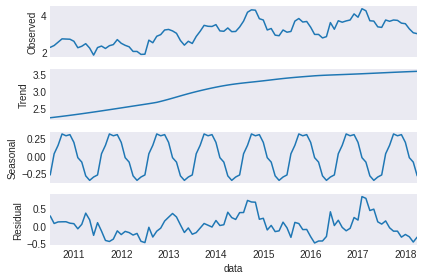

In [ ]:
def decomposicao_temporal(df, coluna, periodo = 365, alter_df = True):
  a = stldecompose.decompose(df[f'{coluna}'], period = periodo)
  prev = stldecompose.forecast(a, steps = 365,fc_func=drift)
  if alter_df:
    df['sazonal'] = a.seasonal.values
    df['residuos'] = a.resid.values
    df['tendencia'] = a.trend.values
  media_temporal = a.period_averages
  a.plot()
  return prev, media_temporal

prev_suinos1, media_suinos1 = decomposicao_temporal(quebra1, 'PR', 12, True)

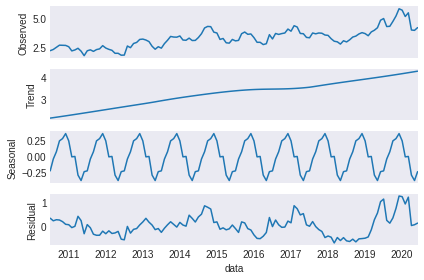

In [ ]:
prev_suinos, media_suinos = decomposicao_temporal(suinos_pr, 'PR', 12, True)

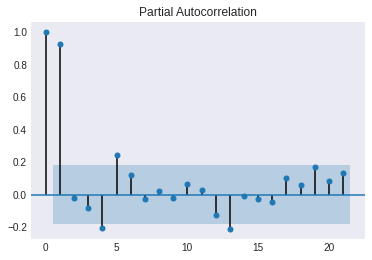

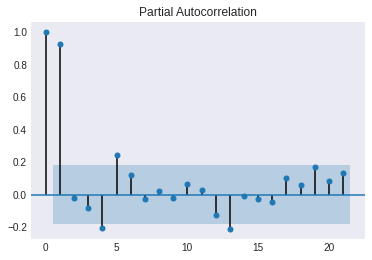

In [ ]:
plot_pacf(suinos_pr['PR'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

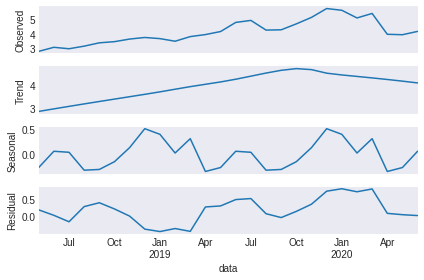

In [ ]:
prev_suinos2, media_suinos2 = decomposicao_temporal(quebra2, 'PR', 12, True)

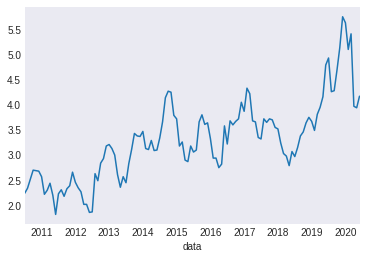

In [ ]:
suinos_pr['PR'].plot()

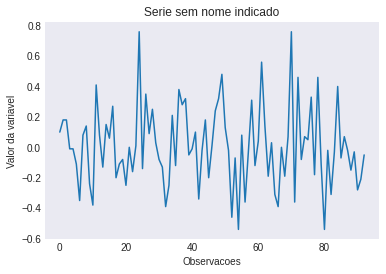

O valor de Gamma é 0.9994610019023457, portanto, tem-se que o valor do beta é aprox. 1.9994610019023455 

De acordo com o teste de ADF, temos que tau (absoluto) = 6.027345364001262 enquanto o 5% critico = 2.895783561573195
     Portanto, temos uma serie estacionaria

 FAC:


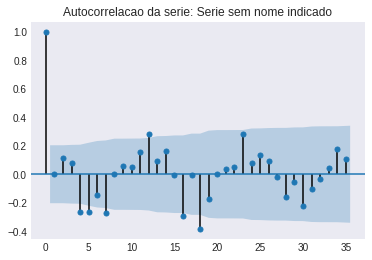

In [ ]:
unit_root_test(np.diff(suinos_pr.loc[suinos_pr['dt1'] == 1]['PR']))

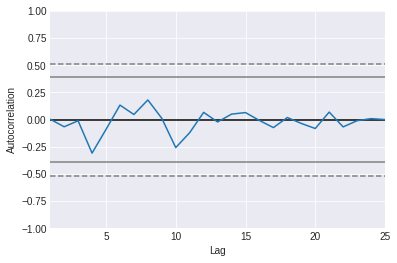

In [ ]:
autocorrelation_plot(np.diff(suinos_pr.loc[suinos_pr['dt2'] == 1]['PR']))

#### Previsao com modelo drift:

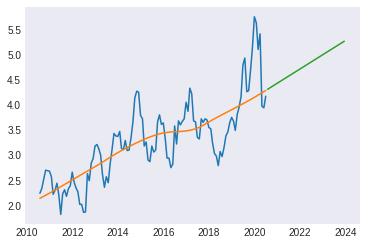

In [ ]:
plt.plot(suinos_pr['PR'])
plt.plot(suinos_pr['tendencia'])
plt.plot(prev_suinos.loc[prev_suinos.index <='2024']);

In [ ]:
quebra1

,PR,dt1,dt2,sazonal,residuos,tendencia
data,,,,,,
2010-07-31,2.24,1,0,-0.269271,0.286996,2.222275
2010-08-31,2.34,1,0,0.034228,0.069998,2.235774
2010-09-30,2.52,1,0,0.155420,0.114975,2.249604
2010-10-31,2.70,1,0,0.317847,0.118373,2.263780
2010-11-30,2.69,1,0,0.291880,0.119810,2.278311
...,...,...,...,...,...,...
2017-12-31,3.55,1,0,0.308277,-0.321237,3.562960
2018-01-31,3.52,1,0,0.197074,-0.244933,3.567859
2018-02-28,3.24,1,0,-0.021779,-0.310806,3.572585


Text(0.5, 1.0, 'Quebra Temporal Suinos')

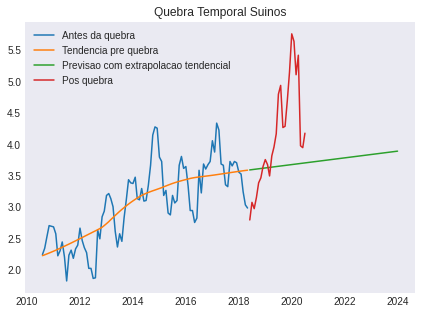

In [ ]:
fig, axs1 = plt.subplots(1, 1, figsize = (7, 5))

axs1.plot(quebra1['PR'], label = 'Antes da quebra')
axs1.plot(quebra1['tendencia'], label = 'Tendencia pre quebra')
axs1.plot(prev_suinos1.loc[prev_suinos1.index <='2024'], label = 'Previsao com extrapolacao tendencial')
axs1.plot(quebra2['PR'], label = 'Pos quebra')
axs1.legend()
axs1.set_title('Quebra Temporal Suinos')

In [ ]:
unit_root_test(np.diff(quebra2['PR']), nome = 'Pos quebra temporal suinos em diferenca' )

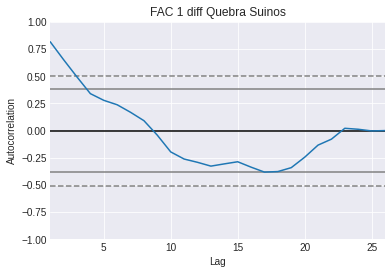

In [ ]:
autocorrelation_plot(quebra2['PR'])
plt.title('FAC 1 diff Quebra Suinos');

### **Milho**

In [ ]:
milho = pd.read_csv('/content/drive/My Drive/Grupo 1 Econometria/milho_semanal.csv')
milho = pd.DataFrame(milho[['preco reais', 'data']])
milho['data'] = pd.to_datetime(milho['data'])
milho.set_index('data', inplace = True)

dummyt1m = list()
dummyt2m = list()
for i in milho.index:
  if i.year == 2017 and i.month >= 8:
      dummyt1m.append(0)
      dummyt2m.append(1)
  elif i.year > 2017:
    dummyt1m.append(0)
    dummyt2m.append(1)
  else:
    dummyt1m.append(1)
    dummyt2m.append(0)

milho['dt1'] = dummyt1m
milho['dt2'] = dummyt2m

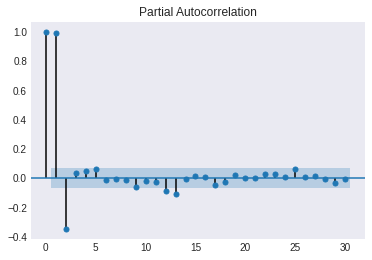

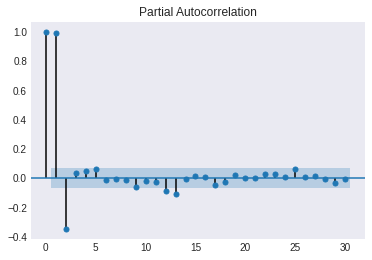

In [ ]:
plot_pacf(milho['preco reais'])

In [ ]:
milho.head()

,preco reais,dt1,dt2
data,,,
2004-08-08,18.098,1,0
2004-08-15,18.028,1,0
2004-08-22,18.322,1,0
2004-08-29,18.786,1,0
2004-09-05,19.028,1,0


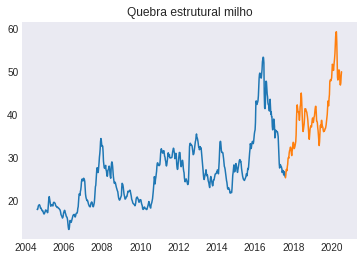

In [ ]:
quebra1m = milho.loc[milho['dt1'] == 1]
quebra2m = milho.loc[milho['dt2'] == 1]

plt.plot(quebra1m['preco reais'])
plt.plot(quebra2m['preco reais'])
plt.title('Quebra estrutural milho')
plt.show()

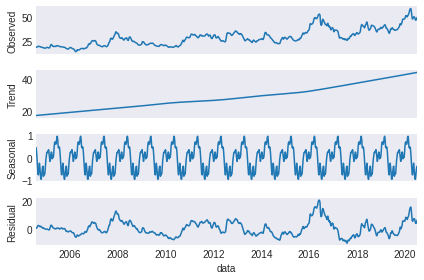

In [ ]:
prev_milho, media_milho = decomposicao_temporal(milho, 'preco reais', 51)

In [ ]:
a = sm.OLS(milho['preco reais'][:-5], milho[['dt1', 'dt2', 'sazonal', 'residuos', 'tendencia']][:-5])

In [ ]:
resultado = a.fit()
resultado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            preco reais   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.658e+31
Date:                Fri, 07 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:19:06   Log-Likelihood:                 25101.
No. Observations:                 827   AIC:                        -5.019e+04
Df Residuals:                     822   BIC:                        -5.017e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dt1        -1.688e-14   3.16e-15     -5.348      0.000   -2.31e-14   -1.07e-14
dt2        -1.069e-14   4.97e-15     -2.152      0.032   -2.04e-14   -9.38e-16
sazonal        1.0000   1.06e-15    9.4e+14      0.000       1.000       1.000
residuos       1.0000   1.06e-16   9.47e+15      0.000       1.000       1.000
tendencia      1.0000    1.2e-16   8.35e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                      206.217   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              413.165
Skew:                          -1.424   Prob(JB):                     1.92e-90
Kurtosis:                       4.970   Cond. No.                         307.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

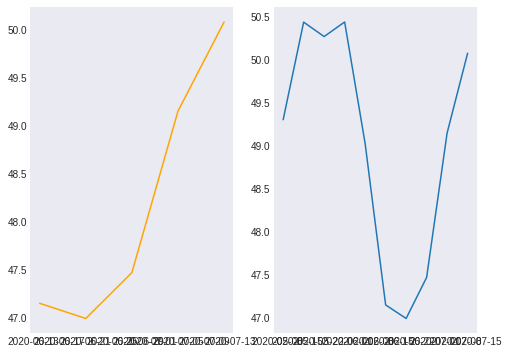

In [ ]:

fig, axs  = plt.subplots(1, 2, figsize = (8, 6))
axs[0].plot(resultado.predict(milho[['dt1', 'dt2', 'sazonal', 'residuos', 'tendencia']][-5:]), color = 'orange')

axs[1].plot(milho['preco reais'][-10:])

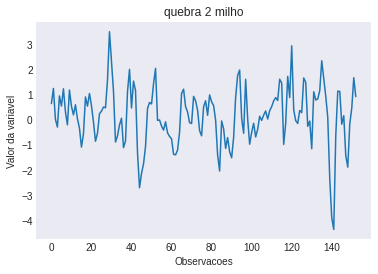

O valor de Gamma é 0.3921076862743023, portanto, tem-se que o valor do beta é aprox. 1.3921076862743023 

De acordo com o teste de ADF, temos que tau (absoluto) = 7.339330448114366 enquanto o 5% critico = 2.880878382771059
     Portanto, temos uma serie estacionaria

 FAC:


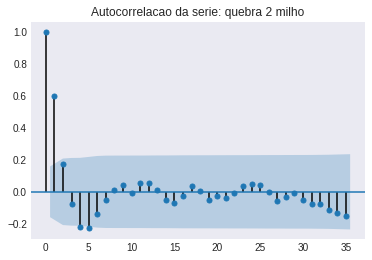

In [ ]:
unit_root_test(np.diff(quebra2m['preco reais']), nome = 'quebra 2 milho')

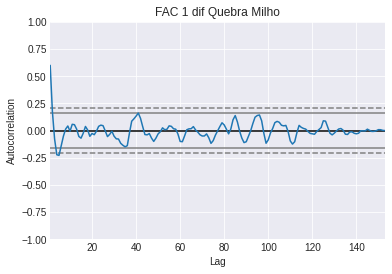

In [ ]:
autocorrelation_plot(np.diff(quebra2m['preco reais']))
plt.title('FAC 1 dif Quebra Milho');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

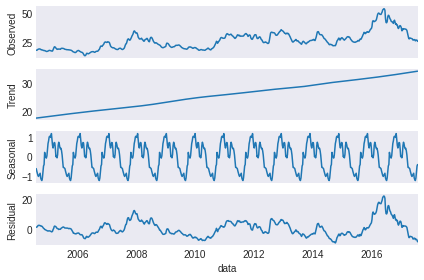

In [ ]:
prev_milho1, media1 = decomposicao_temporal(quebra1m, 'preco reais', 51)

#### Previsao com modelo drift

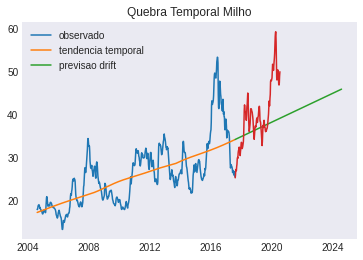

In [ ]:
plt.plot(quebra1m['preco reais'], label = 'observado')
plt.plot(quebra1m['tendencia'], label = 'tendencia temporal')
plt.plot(prev_milho1.loc[prev_milho1.index <='2027'], label = 'previsao drift')
plt.plot(quebra2m['preco reais'])
plt.title('Quebra Temporal Milho')
plt.legend();

## Previsao ARIMA

#### **Suinos**

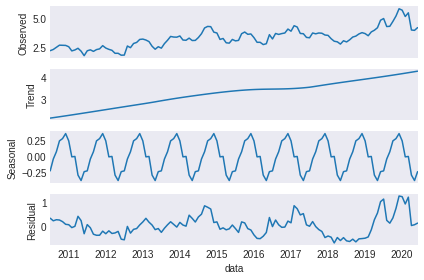

In [ ]:
### Decomposicao temporal dos suinos
prev_suinos, media_suinos = decomposicao_temporal(suinos_pr, 'PR', 12, True)

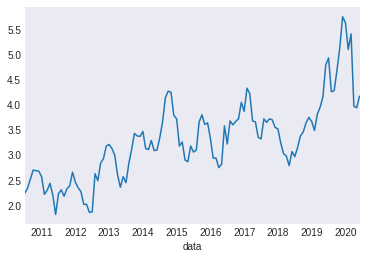

In [ ]:
suinos_pr['PR'].plot()

In [ ]:
suinos_pr.iloc[50]

PR           4.140000
sazonal      0.072450
residuos     0.841189
tendencia    3.226362
Name: 2014-09-30 00:00:00, dtype: float64

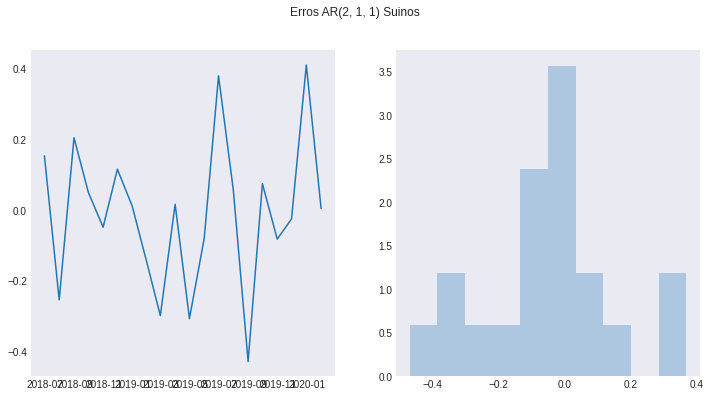

In [ ]:
train_suinos, test_suinos = quebra2['PR'][:-5], quebra2['PR'][-5:]

ar_suinos1 = ARIMA(train_suinos, order = (2, 1, 1), freq = 'M')
fitted_suinos1 = ar_suinos1.fit()
resid_ar1 = fitted_suinos1.resid

fig, (ax1, ax2)  = plt.subplots(1, 2,figsize = (12, 6))
fig.suptitle('Erros AR(2, 1, 1) Suinos')
ax1.plot(resid_ar1)

ax2.hist(resid_ar1, density = True, alpha = 0.3, align = 'left')


fig.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


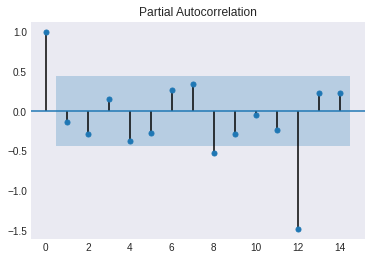

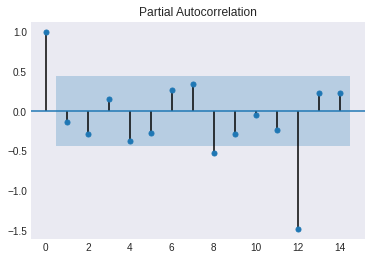

In [ ]:
plot_pacf(fitted_suinos1.resid)
# plt.title('FAC erros (2,1,1) milho');

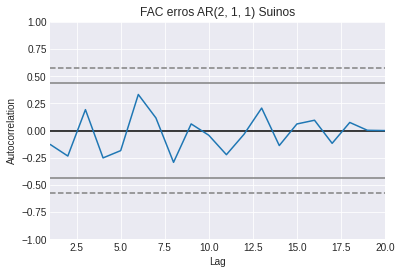

In [ ]:
autocorrelation_plot(fitted_suinos1.resid)
plt.title('FAC erros AR(2, 1, 1) Suinos')
plt.show()

In [ ]:
predictions_s = list()
history = [x for x in train_suinos]
for t in range(len(test_suinos)):
	model_fit = fitted_suinos1
	output = model_fit.forecast(steps = 5)
	yhat = output[0]
	predictions_s.append(yhat[t])
	obs = test_suinos[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat[t], obs))

predicted=5.262515, expected=5.100000
predicted=5.192491, expected=5.410000
predicted=5.495333, expected=3.970000
predicted=5.874241, expected=3.940000
predicted=6.067634, expected=4.170000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


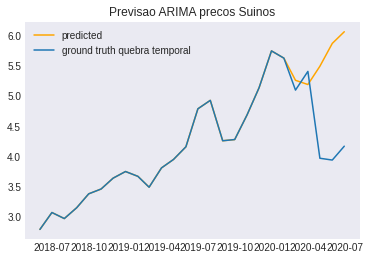

In [ ]:
arima_s = [i for i in train_suinos]
for i in predictions_s:
  arima_s.append(i)
quebra2['arima'] = arima_s

# plt.plot(quebra2['PR'][-15:], label = 'ground truth')
plt.plot(quebra2['arima'], label = 'predicted', color = 'orange')
plt.plot(quebra2['PR'], label = 'ground truth quebra temporal')

plt.legend()
plt.title('Previsao ARIMA precos Suinos')
plt.show()


#### **Milho**

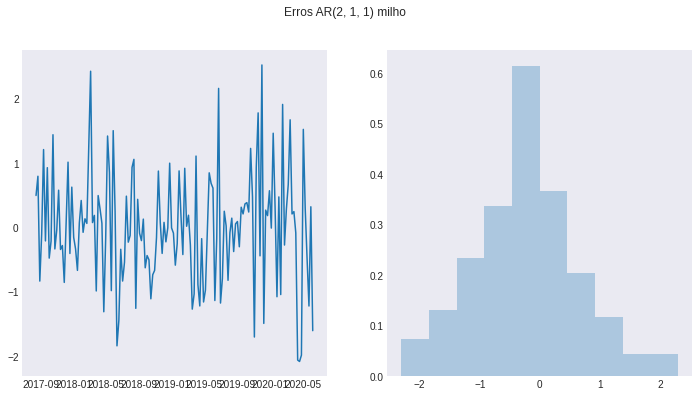

In [ ]:
train_milho, test_milho = quebra2m['preco reais'][:-5], quebra2m['preco reais'][-5:]

ar_suinos1 = ARIMA(train_milho, order = (2, 1, 1), freq  = 'W')
fitted_milho1 = ar_suinos1.fit()
resid_ar1 = fitted_milho1.resid

fig, (ax1, ax2)  = plt.subplots(1, 2,figsize = (12, 6))
fig.suptitle('Erros AR(2, 1, 1) milho ')
ax1.plot(resid_ar1)

ax2.hist(resid_ar1, density = True, alpha = 0.3, align = 'left')


fig.show()


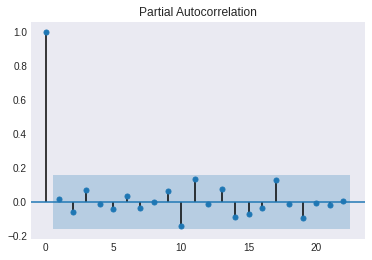

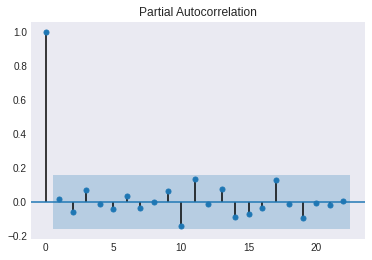

In [ ]:
plot_pacf(fitted_milho1.resid)

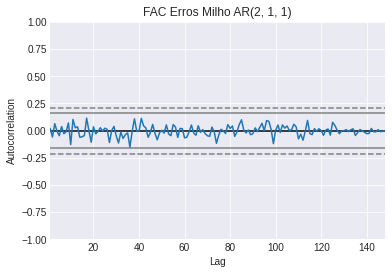

In [ ]:
autocorrelation_plot(fitted_milho1.resid)
plt.title('FAC Erros Milho AR(2, 1, 1)')
plt.show()

In [ ]:
predictions = list()
history = [x for x in train_milho]
for t in range(len(test_milho)):
	output = fitted_milho1.forecast(steps = 5)
	yhat = output[0]
	predictions.append(yhat[t])
	obs = test_milho[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat[t], obs))

predicted=48.067581, expected=47.150000
predicted=47.709937, expected=46.992000
predicted=47.837277, expected=47.470000
predicted=48.229594, expected=49.152000
predicted=48.684170, expected=50.080000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


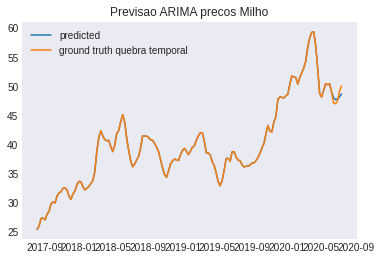

In [ ]:
arima = [i for i in quebra2m['preco reais'].values[:-5]]
for i in predictions:
  arima.append(i)
arima[-5:], predictions
quebra2m['arima'] = arima

plt.plot(quebra2m['arima'], label = 'predicted')
plt.plot(quebra2m['preco reais'], label = 'ground truth quebra temporal')


plt.legend()
plt.title('Previsao ARIMA precos Milho')
plt.show()